In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip "/content/drive/MyDrive/병해작물/235842_작물 병해 분류 AI 경진대회_data.zip"
!pip install timm

Archive:  /content/drive/MyDrive/병해작물/235842_작물 병해 분류 AI 경진대회_data.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Requirement already satisfied: timm in /usr/local/lib/python3.7/dist-packages (0.4.12)


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import timm
from pprint import pprint

In [26]:
train_total = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

# train_total = pd.DataFrame(train_total)
# test = pd.DataFrame(test)

train_total.head()

,uid,img_path,disease,disease_code
0,10000,train_imgs/10000.jpg,시설포도노균병,1
1,10001,train_imgs/10001.jpg,시설포도노균병,1
2,10002,train_imgs/10002.jpg,시설포도노균병반응,2
3,10003,train_imgs/10003.jpg,축과병,4
4,10004,train_imgs/10004.jpg,시설포도노균병,1


### 라벨별 데이터 개수를 이용하여 weight를 줄 예정

In [27]:
train_total = pd.read_csv('./data/train.csv')
pd.value_counts(train_total['disease_code'].values)

0    106
1     46
2     30
3     29
4     17
5     12
6     10
dtype: int64

# Data Parsing

In [1]:
import torch
from torch.utils.data import Dataset

import albumentations as A
from sklearn.model_selection import train_test_split, StratifiedKFold

import cv2
import os
import numpy as np
from glob import glob

import pandas as pd

In [2]:
class TrainDataset(Dataset):
    def __init__(self, img_list, label_list, transforms=None):
        self.img_list = img_list
        self.label_list = label_list
        self.transforms = transforms

    def __getitem__(self, idx):
        img = cv2.imread(self.img_list[idx], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transforms :
            img = self.transforms(image=img)["image"]

        img = img.transpose(2, 0, 1)
        label = self.label_list[idx]

        img = torch.tensor(img, dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)

        return img, label

    def __len__(self):
        assert len(self.img_list) == len(self.label_list)
        return len(self.img_list)

In [3]:
class DataParser() :
    def __init__(self, data_path, random_seed, resize):
        self.img_list, self.label_list = self.get_data(data_path)
        self.random_seed = random_seed
        self.resize = resize


    def get_data(self, data_path):
        
        data = pd.read_csv(data_path)

        upper_path = data_path.split('/')[-1]

        img_list = []
        label_list = []
        for i in range(len(data['img_path'])) :
            img_list.append(data_path.replace(upper_path, data['img_path'][i]))
            label_list.append(data['disease_code'][i])
    
        return img_list, label_list

    
    def get_fold_data(self, fold_datalist):
        imgs = [self.img_list[i] for i in fold_datalist]
        labels = [self.label_list[i] for i in fold_datalist]

        return imgs, labels
        
        
        
    def get_transforms(self, train=True):
        if train :
            transforms = A.Compose([
                A.Resize(self.resize + 20,self.resize + 20),
                A.RandomCrop(self.resize, self.resize),
                A.Rotate(),
                A.HorizontalFlip(),
#                 A.ColorJitter(),
                A.Normalize()
            ])
        else :
            transforms = A.Compose([
                A.Resize(224, 224),
                A.Normalize()
            ])

        return transforms
    
    
    def DatasetParsing(self, fold_train=None, fold_valid=None):
        if fold_train is None :
            train_imgs, valid_imgs, train_labels, valid_labels = train_test_split(self.img_list,
                                                                                  self.label_list,
                                                                                  train_size=0.9,
                                                                                  shuffle=True,
                                                                                  random_state=self.random_seed,
                                                                                  stratify=self.label_list)
        else :
            train_imgs, train_labels = self.get_fold_data(fold_train)
            valid_imgs, valid_labels = self.get_fold_data(fold_valid)

        train_transforms = self.get_transforms()
        valid_transforms = self.get_transforms(train=False)

        train_dataset = TrainDataset(img_list=train_imgs, label_list=train_labels, transforms=train_transforms)
        valid_dataset = TrainDataset(img_list=valid_imgs, label_list=valid_labels, transforms=valid_transforms)

        return train_dataset, valid_dataset

# Cutmix 사용을 위한 Random bbox 

In [4]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

# Train

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

import numpy as np
from easydict import EasyDict
import timm
import random

import wandb
from time import time

ModuleNotFoundError: No module named 'wandb'

In [ ]:
class Train():
    def __init__(self, args):
        self.model_name = args.model_name
        self.export = args.export

        self.epoch = args.epoch
        self.batch_size = args.batch_size
        self.lr = args.learning_rate

        self.k_fold_n = args.k_fold_n
        self.early_stop = args.early_stop
        self.resize = args.resize

        self.cosine_lr_Tmax = args.cosine_lr_Tmax
        self.cosine_lr_eta_min = args.cosine_lr_eta_min
        
        self.train_path = args.train_path
        self.test_path = args.test_path
        self.num_classes = args.num_classes

        self.random_seed = args.random_seed
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.weights = self.cal_weights(self.train_path, self.num_classes) if args.weights else None

        self.args = args
        # self.CUDA_NUMPY_SETTING(random_seed=args.random_seed)

    def create_model(self, model_name, num_classes):
        model = timm.create_model(model_name,pretrained=True, num_classes=num_classes).to(device=self.device)
        return model


    def CUDA_NUMPY_SETTING(self, random_seed=11):
        torch.manual_seed(random_seed)
        torch.manual_seed_all(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        np.random.seed(random_seed)
        random.seed(random_seed)

        print("==" * 30)
        print("USING CUDA is ",torch.cuda.is_available())
        print("DETECTED GPU NUMNER : ", torch.cuda.current_device())
        print("Using ", torch.cuda.device_count()," GPUs")
        for i in range(torch.cuda.device_count()) :
            print("GPU name is ", torch.cuda.get_device_name(i))
        print("==" * 30)

        
    def cal_ACC(self, pred, label):
        preds = pred.argmax(dim=-1)
        comp_list = (preds==label).cpu().tolist()

        cnt = 0
        for i in comp_list :
            if i == True : cnt += 1

        return cnt / len(preds)

    
    def cal_weights(self, data_path, num_classes) :
        train_total = pd.read_csv(data_path)
        num_label = np.array([pd.value_counts(train_total['disease_code'].values)[i] for i in range(num_classes)])
        return torch.tensor(np.max(num_label)/num_label).to(self.device, dtype=torch.float)
        

    def model(self,datasetWeights=None):
        model = self.create_model(self.model_name, num_classes=self.num_classes)
        criterion = nn.CrossEntropyLoss(weight=(datasetWeights).to(device=self.device, dtype=torch.float)
                                        if datasetWeights is not None
                                        else None)
        optimizer = AdamW(params=model.parameters(), lr=self.lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=self.cosine_lr_Tmax, eta_min=self.cosine_lr_eta_min)

        return model, criterion, optimizer, scheduler


    def run(self, train_loader, valid_loader, weights):
        
        results = {
            'train_acc': [],
            'train_loss': [],
            'valid_loss': [],
            'valid_acc': [],
            'valid_f1': []
        }

        best_snapshot = {
            'best_epoch': 0,
            'best_f1': 0,
            'best_model': None
        }

        early_stop_cout = 0

        model, criterion, optimizer, scheduler = self.model(weights)

        wandb.init(project='vit', entity='quhb2455',  config=self.args)
#         wandb.watch(model, criterion, log="all", log_freq=1)
        
        for E in range(1, self.epoch + 1):
            model.train()

            iter_results = {
                'train_acc': [],
                'train_loss': [],
                'valid_loss': [],
                'valid_acc': [],
                'valid_f1': []
            }
            start_t = time()
            # iter
            for iter, (batch_img, batch_label) in enumerate(train_loader, start=1):
                imgs = batch_img.to(device=self.device, dtype=torch.float)
                labels = batch_label.to(device=self.device)
                
                optimizer.zero_grad()
                
                lam = np.random.beta(1.0, 1.0)
                rand_index = torch.randperm(imgs.size()[0])
                target_a = labels
                target_b = labels[rand_index]
                bbx1, bby1, bbx2, bby2 = rand_bbox(imgs.size(), lam)
                imgs[:, :, bbx1:bbx2, bby1:bby2] = imgs[rand_index, :, bbx1:bbx2, bby1:bby2]
                
                # adjust lambda to exactly match pixel ratio
                lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (imgs.size()[-1] * imgs.size()[-2]))
                      
                

                pred = model(imgs)
                loss = criterion(pred, target_a) * lam + criterion(pred, target_b) * (1. - lam)
#                 loss = criterion(pred, labels)

                loss.backward()
                optimizer.step()
                
                iter_results['train_acc'].append(self.cal_ACC(pred, labels))
                iter_results['train_loss'].append(loss.cpu().item())

                print(f"Epoch [{E} / {self.epoch}]      Iter [{iter} / {len(train_loader)}]", end="\r")

                
                
            # eval
            with torch.no_grad():
                for iter, (batch_img, batch_label) in enumerate(valid_loader, start=1):
                    model.eval()

                    imgs = batch_img.to(device=self.device, dtype=torch.float)
                    labels = batch_label.to(device=self.device)

                    val_pred = model(imgs)
                    val_pred_argmax = val_pred.argmax(dim=-1)
                    val_loss = criterion(val_pred, labels)

                    iter_results['valid_acc'].append(self.cal_ACC(val_pred, labels))
                    iter_results['valid_loss'].append(val_loss.cpu().item())
                    iter_results['valid_f1'].append(f1_score(y_true=labels.cpu().numpy(),
                                                             y_pred=val_pred_argmax.cpu().numpy(),
                                                             average="macro"))

                    print(f"Epoch [{E} / {self.epoch}]      valid_Iter [{iter} / {len(valid_loader)}]", end="\r")

            # print(iter_results['valid_acc'])
            # print(type(iter_results['valid_acc']))
            results['train_acc'].append(np.mean(iter_results['train_acc']))
            results['train_loss'].append(np.mean(iter_results['train_loss']))
            results['valid_acc'].append(np.mean(iter_results['valid_acc']))
            results['valid_loss'].append(np.mean(iter_results['valid_loss']))
            results['valid_f1'].append(np.mean(iter_results['valid_f1']))

            scheduler.step()
            
            wandb.log({
                'Epochs' : E,
                'train_acc' : results['train_acc'][-1].item(),
                'train_loss' : results['train_loss'][-1].item(),
                'valid_acc' : results['valid_acc'][-1].item(),
                'valid_loss' : results['valid_loss'][-1].item(),
                'valid_f1' : results['valid_f1'][-1].item()                
            })
            end_t = time() - start_t
            print(
                f"[Epoch {E} / {self.epoch}] "
                f"Time : {end_t:.4f} s | "
                f"train_acc : {results['train_acc'][-1]:.4f} | "
                f"train_loss : {results['train_loss'][-1]:.4f} | "
                f"valid_acc : {results['valid_acc'][-1]:.4f} | "
                f"valid_loss : {results['valid_loss'][-1]:.4f} | "
                f"valid_f1 : {results['valid_f1'][-1]:.4f}"
            )

            if results['valid_f1'][-1] > best_snapshot['best_f1']:
                best_snapshot['best_f1'] = results['valid_f1'][-1]
                best_snapshot['best_model'] = model
                best_snapshot['best_epoch'] = E
                early_stop_cout = 0

            else:
                early_stop_cout += 1
                print(f"early_stop_couter : {early_stop_cout} / {self.early_stop}")

            if early_stop_cout >= self.early_stop:
                print()
                print("*" * 20)
                print("!! EARLY STOP !!")
                print("*" * 20)
                print()
                break

        return results, best_snapshot

    def train(self):

        Datasets = DataParser(self.train_path, self.random_seed, self.resize)
        
        if self.k_fold_n == False :

            train_dataset, valid_dataset = Datasets.DatasetParsing()

            train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
            valid_loader = DataLoader(valid_dataset, batch_size=self.batch_size, shuffle=True)
            
            results, best_snapshot = self.run(train_loader, valid_loader, self.weights)

            return results, best_snapshot

        else :
            print(f"Training Start [ {self.k_fold_n} ] times")

            # StratifiedKFold가 class 간의  balance를 맞춰주기 때문에 weights는 필요 없음
            kfold = StratifiedKFold(n_splits=self.k_fold_n, random_state=self.random_seed, shuffle=True)

            # kfold_result = {"results": [], "best_snapshot":[]}
            kfold_result = []
            for k, (fold_train, fold_valid) in enumerate(kfold.split(Datasets.img_list, Datasets.label_list), 1) :

                fold_train_dataset, fold_valid_dataset = Datasets.DatasetParsing(fold_train, fold_valid)

                fold_train_loader = DataLoader(fold_train_dataset, batch_size=self.batch_size, shuffle=True)
                fold_valid_loader = DataLoader(fold_valid_dataset, batch_size=self.batch_size, shuffle=True)

                results, best_snapshot = self.run(fold_train_loader, fold_valid_loader, None)

                # kfold_result['results'].append(results) # >> ?? 굳이 저장을 해야하나?
                kfold_result.append(best_snapshot)

                print(f"\n==== Fold [{k} / {self.k_fold_n}]  Best-F1 [{kfold_result[k-1]['best_f1']}] ====\n")

            return kfold_result


In [7]:
def make_new_dir(path) : 
    os.makedirs(path, exist_ok=True)

In [8]:
swin_large_patch4_window7_224_config={
    'model_name' : 'swin_large_patch4_window7_224', # 사용하려는 timm 모델 #  vit_base_patch16_224
    'export' : './data/model', # 학습 후 모델이 저장될 장소
    'batch_size' : 2, 
    'epoch' : 20,
    'k_fold_n': 2, # False 로하면 Epoch만큼 학습, 숫자를 넣으면 해당 횟수로 데이터셋 fold 후 학습
                        # Fold 별로 모델 저장도 진행함.
    'resize' : 224,
    'learning_rate' : 1e-4,
    'cosine_lr_Tmax' : 15,
    'cosine_lr_eta_min' : 1e-5,
    
    'early_stop' : 4,
    'random_seed' : 11, # dataset 셔플용
    'train_path' : './data/train.csv',
    'test_path' : './data/test.csv', # 안씀
    'num_classes' : 7, 
    'weights' : True # dataset 불균형 때문에 넣어봄, loss 계산 시 label 갯수를 기반으로 가중치 추가됨.
}

# ============================================

swin_base_patch4_window7_224_in22k_config={
    'model_name' : 'swin_base_patch4_window7_224_in22k', # 사용하려는 timm 모델 #  vit_base_patch16_224
    'export' : './data/model', # 학습 후 모델이 저장될 장소
    'batch_size' : 8, 
    'epoch' : 20,
    'k_fold_n': 4, # False 로하면 Epoch만큼 학습, 숫자를 넣으면 해당 횟수로 데이터셋 fold 후 학습
                        # Fold 별로 모델 저장도 진행함.
    'resize' : 224,
    'learning_rate' : 1e-4,
    'cosine_lr_Tmax' : 15,
    'cosine_lr_eta_min' : 1e-5,
    
    'early_stop' : 4,
    'random_seed' : 11, # dataset 셔플용
    'train_path' : './data/train.csv',
    'test_path' : './data/test.csv', # 안씀
    'num_classes' : 7, 
    'weights' : True # dataset 불균형 때문에 넣어봄, loss 계산 시 label 갯수를 기반으로 가중치 추가됨.
}

# =============================================

nfnet_l0_config={
    'model_name' : 'nfnet_l0', # 사용하려는 timm 모델 #  vit_base_patch16_224
    'export' : './data/model', # 학습 후 모델이 저장될 장소
    'batch_size' : 16, 
    'epoch' : 20,
    'k_fold_n': 4, # False 로하면 Epoch만큼 학습, 숫자를 넣으면 해당 횟수로 데이터셋 fold 후 학습
                        # Fold 별로 모델 저장도 진행함.
    'resize' : 288,
    'learning_rate' : 1e-4,
    'cosine_lr_Tmax' : 15,
    'cosine_lr_eta_min' : 1e-5,
    
    'early_stop' : 4,
    'random_seed' : 11, # dataset 셔플용
    'train_path' : './data/train.csv',
    'test_path' : './data/test.csv', # 안씀
    'num_classes' : 7, 
    'weights' : True # dataset 불균형 때문에 넣어봄, loss 계산 시 label 갯수를 기반으로 가중치 추가됨.
}

# ========================================

vit_config={
    'model_name' : 'vit_base_patch16_224', # 사용하려는 timm 모델 #  vit_base_patch16_224
    'export' : './data/model', # 학습 후 모델이 저장될 장소
    'batch_size' : 16, 
    'epoch' : 20,
    'k_fold_n': 3, # False 로하면 Epoch만큼 학습, 숫자를 넣으면 해당 횟수로 데이터셋 fold 후 학습
                        # Fold 별로 모델 저장도 진행함.
    'resize' : 224,
    'learning_rate' : 1e-4,
    'cosine_lr_Tmax' : 15,
    'cosine_lr_eta_min' : 1e-5,
    
    'early_stop' : 4,
    'random_seed' : 11, # dataset 셔플용
    'train_path' : './data/train.csv',
    'test_path' : './data/test.csv', # 안씀
    'num_classes' : 7, 
    'weights' : True # dataset 불균형 때문에 넣어봄, loss 계산 시 label 갯수를 기반으로 가중치 추가됨.
}

# args = EasyDict(config)
args = EasyDict(swin_large_patch4_window7_224_config)

In [9]:
print("="*20)
print(args)
print("=" * 20)

make_new_dir(args.export)

training = Train(args)



if args.k_fold_n == False :
    results, best_snapshot = training.train()
    
    print("Training DONE")
    
    torch.save(best_snapshot['best_model'],
               args.export + '/' + str(best_snapshot['best_f1']) + '_' + str(best_snapshot['best_epoch']) + 'E_best_model.pt')

else :
    kfold_best_snapshot = training.train()
    
    print("Training DONE")
    
    for idx, bs in enumerate(kfold_best_snapshot) :
        torch.save(bs['best_model'],
               args.export + '/Kfold_' + str(idx) +'_'+ str(bs['best_f1']) + '_' + str(bs['best_epoch']) + 'E_best_model.pt')


print("SUCCESS to saving the model")



{'model_name': 'swin_large_patch4_window7_224', 'export': './data/model', 'batch_size': 2, 'epoch': 20, 'k_fold_n': 2, 'resize': 224, 'learning_rate': 0.0001, 'cosine_lr_Tmax': 15, 'cosine_lr_eta_min': 1e-05, 'early_stop': 4, 'random_seed': 11, 'train_path': './data/train.csv', 'test_path': './data/test.csv', 'num_classes': 7, 'weights': True}
Training Start [ 2 ] times


wandb: Currently logged in as: quhb2455 (use `wandb login --relogin` to force relogin)


[Epoch 1 / 20] Time : 31.2412 s | train_acc : 0.5238 | train_loss : 1.4425 | valid_acc : 0.8810 | valid_loss : 0.6067 | valid_f1 : 0.8466
[Epoch 2 / 20] Time : 30.5946 s | train_acc : 0.8492 | train_loss : 0.5649 | valid_acc : 0.9603 | valid_loss : 0.1522 | valid_f1 : 0.9524
[Epoch 3 / 20] Time : 30.4067 s | train_acc : 0.8968 | train_loss : 0.4591 | valid_acc : 0.9524 | valid_loss : 0.2022 | valid_f1 : 0.9365
early_stop_couter : 1 / 4
[Epoch 4 / 20] Time : 30.7195 s | train_acc : 0.8730 | train_loss : 0.4728 | valid_acc : 0.9127 | valid_loss : 0.2623 | valid_f1 : 0.8836
early_stop_couter : 2 / 4
[Epoch 5 / 20] Time : 31.0008 s | train_acc : 0.8095 | train_loss : 0.5657 | valid_acc : 0.9683 | valid_loss : 0.1455 | valid_f1 : 0.9577
[Epoch 6 / 20] Time : 30.9422 s | train_acc : 0.8810 | train_loss : 0.3776 | valid_acc : 0.9762 | valid_loss : 0.1018 | valid_f1 : 0.9683
[Epoch 7 / 20] Time : 31.3076 s | train_acc : 0.9286 | train_loss : 0.3445 | valid_acc : 0.9841 | valid_loss : 0.1177 | 

Epochs,▁▂▂▃▄▅▅▆▇▇█
train_acc,▁▆▇▇▆▇█▇▇█▇
train_loss,█▃▂▂▃▂▂▂▁▁▁
valid_acc,▁▆▆▃▇▇█▇▇██
valid_f1,▁▇▆▃▇▇█▇▇██
valid_loss,█▂▂▃▂▁▁▁▁▁▁
Epochs,11
train_acc,0.9127
train_loss,0.25155
valid_acc,0.98413
valid_f1,0.97884


[Epoch 1 / 20] Time : 31.3300 s | train_acc : 0.5476 | train_loss : 1.4848 | valid_acc : 0.7937 | valid_loss : 0.7664 | valid_f1 : 0.7354
[Epoch 2 / 20] Time : 31.2770 s | train_acc : 0.7698 | train_loss : 0.7869 | valid_acc : 0.8095 | valid_loss : 0.6062 | valid_f1 : 0.7513
[Epoch 3 / 20] Time : 31.2911 s | train_acc : 0.7857 | train_loss : 0.6425 | valid_acc : 0.9206 | valid_loss : 0.2700 | valid_f1 : 0.8942
[Epoch 4 / 20] Time : 31.7616 s | train_acc : 0.8889 | train_loss : 0.4413 | valid_acc : 0.9365 | valid_loss : 0.1971 | valid_f1 : 0.9153
[Epoch 5 / 20] Time : 31.3185 s | train_acc : 0.9127 | train_loss : 0.4029 | valid_acc : 0.9444 | valid_loss : 0.3044 | valid_f1 : 0.9259
[Epoch 6 / 20] Time : 32.0415 s | train_acc : 0.8889 | train_loss : 0.4483 | valid_acc : 0.9127 | valid_loss : 0.3703 | valid_f1 : 0.8889
early_stop_couter : 1 / 4
[Epoch 7 / 20] Time : 32.3084 s | train_acc : 0.9524 | train_loss : 0.2581 | valid_acc : 0.9365 | valid_loss : 0.2001 | valid_f1 : 0.9153
early_st

# Test - inference

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import os
from glob import glob

In [2]:
class TestDataset(Dataset) :
    def __init__(self, img_list, transforms=None):
        self.img_list = img_list
        self.transforms = transforms

    def __getitem__(self, idx):
        img = cv2.imread(self.img_list[idx], cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transforms :
            img = self.transforms(image=img)["image"]

        img = img.transpose(2, 0, 1)

        img = torch.tensor(img, dtype=torch.float)

        return img

    def __len__(self):
        return len(self.img_list)

In [3]:
def get_models(model_list) :
    return [torch.load(model).eval() for model in model_list]

def softvoting(models, img, n_classes=7) :

    predicts = torch.zeros(img.size(0), n_classes)
    for model in models :
        output = model(img)
        output = F.softmax(output.cpu(), dim=1)
        predicts += output

    # 둘다 값은 똑같이 나옴.
    # pred_avg = predicts / len(models)
    # answer = pred_avg.argmax(dim=-1)
    # _, answer2 = torch.max(pred_avg, 1)

    return predicts.detach().cpu() / len(models)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

path ='./data/test.csv'

test = pd.read_csv(path)
upper_path = path.split('/')[-1]

test_path = [path.replace(upper_path, test['img_path'][i]) for i in range(len(test))]

transforms = A.Compose([
    A.Resize(224, 224),
    A.Normalize()
])

test_dataset = TestDataset(test_path, transforms=transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [5]:
model_path='./data/model/nfnet_vit_swin_Large'
models = get_models(glob(model_path+'/*.pt'))
n_classes = 7


In [ ]:
model_path='./data/model/1.0_4E_best_model.pt'
model = torch.load(model_path).eval()

In [6]:


results = []
for img in tqdm(test_loader) :
    img = img.to(device=device)
    
    predictions = softvoting(models, img)
#     prediction = model(img)
    
#     results.append(int(torch.argmax(prediction.detach().cpu())))
    results.append(int(torch.argmax(predictions[0])))
    
#     output = F.softmax(prediction.detach().cpu(), dim=1)
#     print(output)
#     (torch.argmax(output[0]))

print(results)

100%|██████████████████████████████████████████████████████████████████████████████| 4750/4750 [20:47<00:00,  3.81it/s]

[5, 1, 0, 0, 2, 0, 2, 0, 0, 0, 3, 0, 4, 1, 0, 0, 3, 3, 5, 3, 0, 0, 6, 3, 5, 3, 2, 3, 1, 4, 2, 1, 0, 1, 0, 2, 0, 1, 0, 3, 2, 2, 1, 4, 2, 0, 4, 0, 0, 0, 1, 3, 3, 6, 0, 0, 0, 2, 0, 5, 4, 5, 0, 0, 3, 0, 0, 0, 0, 3, 0, 1, 3, 4, 1, 0, 3, 2, 0, 6, 1, 4, 0, 2, 1, 0, 2, 0, 2, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 3, 0, 1, 1, 0, 0, 4, 4, 5, 2, 2, 0, 0, 0, 0, 3, 0, 0, 0, 2, 0, 2, 0, 4, 1, 5, 0, 0, 0, 2, 4, 2, 1, 3, 0, 0, 2, 0, 3, 0, 0, 1, 2, 4, 2, 4, 6, 6, 4, 5, 0, 2, 1, 1, 0, 3, 5, 0, 2, 5, 0, 1, 1, 0, 1, 0, 0, 0, 5, 5, 0, 3, 2, 4, 0, 2, 0, 5, 3, 0, 3, 0, 2, 0, 1, 3, 1, 0, 1, 0, 0, 0, 0, 1, 2, 0, 3, 3, 0, 0, 0, 0, 3, 1, 0, 0, 5, 1, 6, 1, 0, 0, 3, 3, 1, 0, 0, 0, 4, 6, 0, 6, 3, 2, 6, 3, 6, 1, 2, 0, 1, 1, 2, 0, 0, 2, 4, 0, 1, 3, 0, 1, 3, 0, 1, 2, 3, 2, 3, 3, 4, 5, 3, 0, 0, 0, 5, 1, 2, 0, 1, 2, 0, 4, 2, 1, 0, 0, 1, 0, 0, 3, 1, 1, 0, 0, 1, 2, 0, 0, 0, 3, 5, 4, 0, 1, 0, 0, 2, 0, 0, 0, 1, 4, 3, 2, 1, 0, 1, 0, 0, 3, 0, 0, 0, 2, 0, 3, 1, 4, 0, 1, 0, 4, 0, 0, 0, 3, 2, 5, 0, 4, 0, 0, 5, 0, 3, 0, 0, 2, 0, 0, 2, 

In [7]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.iloc[:,1] = results
submission.to_csv('nfnet_vit_swin_Large.csv', index=False)

In [7]:
model = timm.create_model('efficientnetv2_rw_s', pretrained=True, num_classes=7)
# model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=7)

import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['adv_inception_v3',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'cspdarknet53',
 'cspresnet50',
 'cspresnext50',
 'deit_base_distilled_patch16_224',
 'deit_base_distilled_patch16_384',
 'deit_base_patch16_224',
 'deit_base_patch16_384',
 'deit_small_distilled_patch16_224',
 'deit_small_patch16_224',
 'deit_tiny_distilled_patch16_224',
 'deit_tiny_patch16_224',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'densenetblur121d',
 'dla34',
 'dla46_c',
 'dla46x_c',
 'dla60',
 'dla60_res2net',
 'dla60_res2next',
 'dla60x',
 'dla60x_c',
 'dla102',
 'dla102x',
 'dla102x2',
 'dla169',
 'dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'dpn68',
 'dpn

In [8]:
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [9]:
# for idx, (k, v) in enumerate(model.named_parameters()):
#   print(idx, k)

# for idx, param in enumerate(model.parameters()):
#     if idx >= 765:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
#     print(idx, param.requires_grad)

In [10]:
def train_step(batch_item, epoch, batch, training):
    img = batch_item['img'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        return loss
    else:
        model.eval()
        with torch.no_grad():
            output = model(img)
            loss = criterion(output, label)
            
        return loss

In [11]:
loss_plot, val_loss_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Total Loss' : '{:06f}'.format(total_loss/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss = train_step(batch_item, epoch, batch, training)
        total_val_loss += batch_loss
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Total Val Loss' : '{:06f}'.format(total_val_loss/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    
    if np.min(val_loss_plot) == val_loss_plot[-1]:
        torch.save(model, save_path)

7it [00:16,  2.43s/it, Epoch=1, Loss=2.294647, Total Loss=2.595269]
2it [00:03,  1.95s/it, Epoch=1, Val Loss=2.288040, Total Val Loss=1.864299]
7it [00:16,  2.31s/it, Epoch=2, Loss=1.185036, Total Loss=0.518740]
2it [00:03,  1.93s/it, Epoch=2, Val Loss=1.239040, Total Val Loss=1.039335]
7it [00:15,  2.27s/it, Epoch=3, Loss=0.673981, Total Loss=0.131293]
2it [00:03,  1.95s/it, Epoch=3, Val Loss=0.836715, Total Val Loss=0.772324]
7it [00:16,  2.32s/it, Epoch=4, Loss=0.136313, Total Loss=0.035211]
2it [00:03,  2.00s/it, Epoch=4, Val Loss=0.706157, Total Val Loss=0.734229]
7it [00:16,  2.31s/it, Epoch=5, Loss=0.156432, Total Loss=0.032473]
2it [00:03,  1.95s/it, Epoch=5, Val Loss=0.792791, Total Val Loss=0.799475]
7it [00:16,  2.30s/it, Epoch=6, Loss=0.048201, Total Loss=0.017607]
2it [00:03,  1.94s/it, Epoch=6, Val Loss=0.800679, Total Val Loss=0.768865]
7it [00:16,  2.30s/it, Epoch=7, Loss=0.099182, Total Loss=0.019057]
2it [00:03,  1.99s/it, Epoch=7, Val Loss=0.843006, Total Val Loss=0.

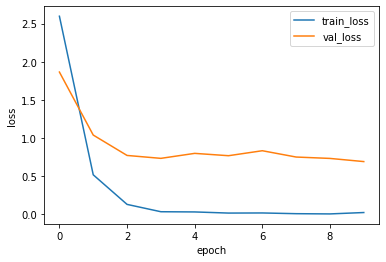

In [12]:
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [13]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    training = False
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        with torch.no_grad():
            output = model(img)
        output = torch.tensor(torch.argmax(output, axis=-1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

In [14]:
preds = predict(test_dataloader)

0it [00:00, ?it/s]c:\users\quhb2\anaconda3\envs\torch-1.9\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
149it [05:57,  2.40s/it]


In [15]:
submission = pd.read_csv('sample_submission.csv')
submission.iloc[:,1] = preds
submission.to_csv('baseline2.csv', index=False)